In [1]:
import numpy as np
from cluster_data import ClusterData, cluster_data_to_array, normalize_data, estimate_runtime
from kmeans import k_means
from my_kmedoids import pam_clustering
from fuzzy_c_means import fuzzy_c_means
import my_kmedoids
from DBSCAN import dbscan_clustering

def main():
    #Example data: list of ClusterData (3 dimensions: inc, raan, ecc)
    data_list = [
        ClusterData(inc=10.0, raan=20.0),
        ClusterData(inc=12.0, raan=22.0),
        ClusterData(inc=11.0, raan=21.0),
        ClusterData(inc=50.0, raan=60.0),
        ClusterData(inc=52.0, raan=62.0),
        ClusterData(inc=51.0, raan=61.0),
    ]
    
    # Convert the list of named tuples to a numpy array.
    data_array = cluster_data_to_array(data_list)
    
    # Normalize the data.
    normalized_data, data_min, data_max = normalize_data(data_array) 
    k = 2  # Number of clusters
    
    # --- K-means Clustering ---
    print("\nK-means result:")
    result_kmeans, time_kmeans = estimate_runtime(k_means, normalized_data, k, init='random')
    print("Labels:", result_kmeans.labels)
    print("Cluster centers:\n", result_kmeans.cluster_centers)
                                                      
    # --- Fuzzy C-means Clustering ---
    print("\nFuzzy C-means result:")
    result_fcm, time_fcm = estimate_runtime(fuzzy_c_means, normalized_data, k, m=2)
    print("Labels:", result_fcm.labels)
    print("Cluster centers:\n", result_fcm.cluster_centers)                                          

    # --- K-medoids (PAM) Clustering ---
    print("\nK-medoids (PAM) result:")
    result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, build_function=None, swap_function=None)
    print("Labels:", result_kmedoids.labels)
    print("here")
    print("Cluster centers:\n", result_kmedoids.cluster_centers)

    # --- K-medoids (PAM) Clustering --- FastPAM1
    print("\nK-medoids fastPAM 1 result:")
    result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, None, my_kmedoids.fastpam1_swap)
    print("Labels:", result_kmedoids.labels)
    print("Cluster centers:\n", result_kmedoids.cluster_centers) 
    
    # --- K-medoids (PAM) Clustering --- FastPAM2 and LAB Build
    print("\nK-medoids fastPAM2 + LAB-build result:")
    result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, my_kmedoids.fastpam_lab_build, my_kmedoids.fastpam2_swap)
    print("Labels:", result_kmedoids.labels)
    print("Cluster centers:\n", result_kmedoids.cluster_centers)

    print("\nDBSCAN result:")
    result_dbscan, time_dbscan = estimate_runtime(dbscan_clustering, normalized_data, eps=0.5, min_samples=5)
    print(result_dbscan)
    print("Labels:", result_dbscan.labels)
    print("Cluster centers:\n", result_dbscan.cluster_centers)

if __name__ == "__main__":
    main()


K-means result:
Runtime for k_means: 0.000000 seconds
Labels: [1 1 1 0 0 0]
Cluster centers:
 [[0.97619048 0.97619048]
 [0.02380952 0.02380952]]

Fuzzy C-means result:
Runtime for fuzzy_c_means: 0.000000 seconds
Labels: [0 0 0 1 1 1]
Cluster centers:
 [[0.02380883 0.02380883]
 [0.97619115 0.97619115]]

K-medoids (PAM) result:
Runtime for pam_clustering: 0.000000 seconds
Labels: [0 0 0 1 1 1]
here
Cluster centers:
 [[0.02380952 0.02380952]
 [0.97619048 0.97619048]]

K-medoids fastPAM 1 result:
Runtime for pam_clustering: 0.000000 seconds
Labels: [0 0 0 1 1 1]
Cluster centers:
 [[0.02380952 0.02380952]
 [0.97619048 0.97619048]]

K-medoids fastPAM2 + LAB-build result:
Runtime for pam_clustering: 0.000000 seconds
Labels: [0 0 0 1 1 1]
Cluster centers:
 [[0.02380952 0.02380952]
 [0.97619048 0.97619048]]

DBSCAN result:
Runtime for dbscan_clustering: 0.193311 seconds
ClusteringResult(labels=array([-1, -1, -1, -1, -1, -1], dtype=int64), cluster_centers=array([], dtype=float64), data=array([[

c:\Users\fionu\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Das System kann die angegebene Datei nicht finden
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\fionu\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\fionu\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fionu\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\fionu\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.C

In [1]:
import numpy as np
import cluster_data
import my_kmedoids
from cluster_plotter import ClusterPlotter
from kmeans import k_means
from fuzzy_c_means import fuzzy_c_means
from my_kmedoids import pam_clustering
from DBSCAN import dbscan_clustering
from mean_shift import mean_shift_clustering
import scores

from cluster_data import run_clustering

# Load and preprocess data
testfile = r"../input/stat_Master_02_geo_s1.crs"
data = cluster_data.prepare_data_for_clustering(testfile)
data = np.array(data).T
normalized_data, data_min, data_max = cluster_data.normalize_data(data)
k = 2  # Number of clusters

list_alg = ["K - Means", "Fuzzy C Means", "FAST PAM 1", "FAST PAM 2", "K - Medoids", "K-medoids fastPAM2 + LAB-build", "DBSCAN"]

# Run clustering algorithms
result_mean_shift, time_mean_shift, n_clusters_mean_shift, points_per_cluster_mean_shift, metrics_mean_shift = run_clustering(mean_shift_clustering, "Mean Shift", normalized_data, data_min, data_max)
result_kmeans, time_kmeans, n_clusters_kmeans, points_per_cluster_kmeans, metrics_kmeans = run_clustering(k_means, "K-means", normalized_data, data_min, data_max,  plot = True, k = k, init='kmeans++')
result_fcm, time_fcm, n_clusters_fcm, points_per_cluster_fcm, metrics_fcm = run_clustering(fuzzy_c_means, "Fuzzy C-means", normalized_data, data_min, data_max, plot = True, k = k, m=2)
result_fastpam1, time_fastpam1,n_clusters_fastpam1, points_per_cluster_fastpam1, metrics_fastpam1 = run_clustering(pam_clustering, "K-medoids fastPAM1", normalized_data, data_min, data_max,  plot = True, k = k, build_function = None, swap_function = my_kmedoids.fastpam1_swap)
result_kmedoids, time_kmedoids, n_clusters_kmedoids, points_per_cluster_kmedoids, metrics_kmedoids = run_clustering(pam_clustering, "K-medoids (PAM)", normalized_data, data_min, data_max, plot = True, k= k, build_function=None, swap_function=None)
result_fastpam2, time_fastpam2, n_clusters_fastpam2, points_per_cluster_fastpam2, metrics_fastpam2 = run_clustering(pam_clustering, "K-medoids fastPAM2 + LAB-build", normalized_data, data_min, data_max, plot = True, k = k, build_function = my_kmedoids.fastpam_lab_build, swap_function = my_kmedoids.fastpam2_swap)
result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = cluster_data.estimate_runtime(dbscan_clustering, normalized_data, eps=0.5, min_samples=5, plot = True)

runtimes = [ time_mean_shift, time_kmeans, time_fcm, time_fastpam1, time_kmedoids, time_fastpam2, time_dbscan]
n_clusters = [n_clusters_mean_shift, n_clusters_kmeans, n_clusters_fcm, n_clusters_fastpam1, n_clusters_kmedoids, n_clusters_fastpam2, n_clusters_dbscan]
points_per_clusters = [points_per_cluster_mean_shift, points_per_cluster_kmeans, points_per_cluster_fcm, points_per_cluster_fastpam1, points_per_cluster_kmedoids, points_per_cluster_fastpam2, points_per_cluster_dbscan] 

metrics = [metrics_mean_shift, metrics_kmeans, metrics_fcm, metrics_fastpam1, metrics_kmedoids, metrics_fastpam2, metrics_dbscan]
DB_scores = [metrics_mean_shift[0], metrics_kmeans[0], metrics_fcm[0], metrics_fastpam1[0], metrics_kmedoids[0], metrics_fastpam2[0], metrics_dbscan[0]]
CH_scores = [metrics_mean_shift[1], metrics_kmeans[1], metrics_fcm[1], metrics_fastpam1[1], metrics_kmedoids[1], metrics_fastpam2[1], metrics_dbscan[1]]
dunn_index = [metrics_mean_shift[2], metrics_kmeans[2], metrics_fcm[2], metrics_fastpam1[2], metrics_kmedoids[2], metrics_fastpam2[2], metrics_dbscan[2]]
sil_scores = [metrics_mean_shift[3], metrics_kmeans[3], metrics_fcm[3], metrics_fastpam1[3], metrics_kmedoids[3], metrics_fastpam2[3], metrics_dbscan[3]]
cluster_2d_std = [metrics_mean_shift[4], metrics_kmeans[4], metrics_fcm[4], metrics_fastpam1[4], metrics_kmedoids[4], metrics_fastpam2[4], metrics_dbscan[4]]
square_density = [metrics_mean_shift[5], metrics_kmeans[5], metrics_fcm[5], metrics_fastpam1[5], metrics_kmedoids[5], metrics_fastpam2[5], metrics_dbscan[5]]
hull_density = [metrics_mean_shift[6], metrics_kmeans[6], metrics_fcm[6], metrics_fastpam1[6], metrics_kmedoids[6], metrics_fastpam2[6], metrics_dbscan[6]]

print("\n--- Runtime Summary ---")
print(f"K-means runtime: {time_kmeans:.6f} seconds")
print(f"Fuzzy C-means runtime: {time_fcm:.6f} seconds")
print(f"K-medoids (PAM) runtime: {time_kmedoids:.6f} seconds")
print(f"K-medoids fastPAM1 runtime: {time_fastpam1:.6f} seconds")
print(f"K-medoids fastPAM2 + LAB-build runtime: {time_fastpam2:.6f} seconds")
print(f"DBSCAN runtime: {time_dbscan:.6f} seconds")

print("\nDBSCAN Clustering Result:")
print("Labels:", result_dbscan)

# Unnormalize DBSCAN results
unnormalized_data = cluster_data.unnormalize(normalized_data, None, data_min, data_max)[0]

#plotter = ClusterPlotter(unnormalized_data, result_dbscan, None)
#plotter.clusters_3d_plot("DBSCAN 3D Cluster Visualization")
#plotter.clusters_2d_plot("DBSCAN 2D Cluster Visualization")



Mean Shift result:


AttributeError: 'numpy.ndarray' object has no attribute 'inc'


K-means result:
Runtime for k_means: 0.005091 seconds
Labels: [1 1 1 ... 1 1 1]
Cluster centers:
 [[0.31533987 0.8216823 ]
 [0.63526442 0.5352003 ]]
Runtime: 0.005091 seconds

K-means result:
Runtime for k_means: 0.011743 seconds
Labels: [0 0 0 ... 0 0 0]
Cluster centers:
 [[0.63526442 0.5352003 ]
 [0.31533987 0.8216823 ]]
Runtime: 0.011743 seconds

K-means result:
Runtime for k_means: 0.005104 seconds
Labels: [1 1 1 ... 1 1 1]
Cluster centers:
 [[0.31533987 0.8216823 ]
 [0.63526442 0.5352003 ]]
Runtime: 0.005104 seconds

K-means result:
Runtime for k_means: 0.009643 seconds
Labels: [1 1 1 ... 1 1 1]
Cluster centers:
 [[0.31533987 0.8216823 ]
 [0.63526442 0.5352003 ]]
Runtime: 0.009643 seconds

K-means result:
Runtime for k_means: 0.003169 seconds
Labels: [0 0 0 ... 0 0 0]
Cluster centers:
 [[0.63526442 0.5352003 ]
 [0.31533987 0.8216823 ]]
Runtime: 0.003169 seconds

K-means result:
Runtime for k_means: 0.000000 seconds
Labels: [1 1 1 ... 1 1 1]
Cluster centers:
 [[0.3161501  0.825051

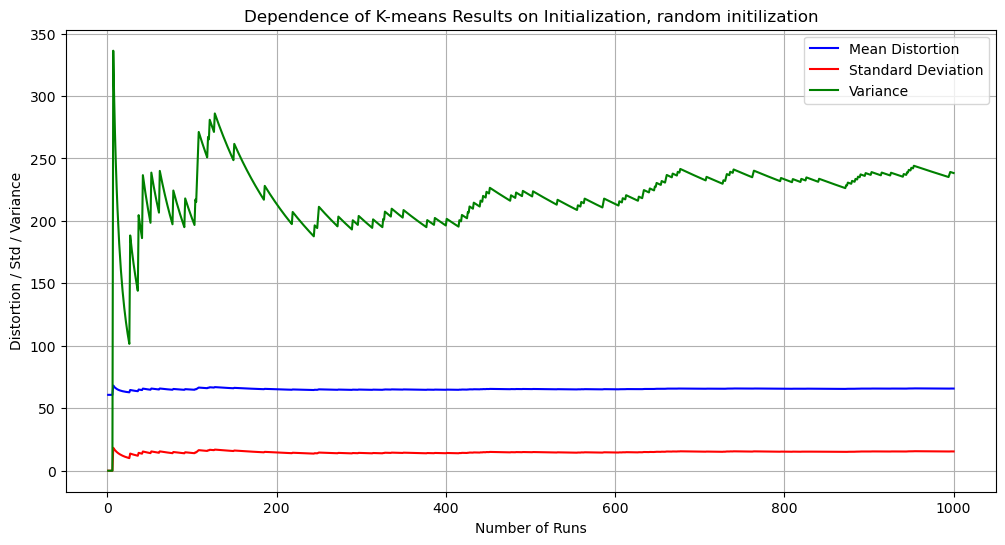


K-means result:
Runtime for k_means: 0.002807 seconds
Labels: [0 0 0 ... 0 0 0]
Cluster centers:
 [[0.63427075 0.5348476 ]
 [0.3161501  0.82505185]]
Runtime: 0.002807 seconds

K-means result:
Runtime for k_means: 0.002575 seconds
Labels: [0 0 0 ... 0 0 0]
Cluster centers:
 [[0.63526442 0.5352003 ]
 [0.31533987 0.8216823 ]]
Runtime: 0.002575 seconds

K-means result:
Runtime for k_means: 0.000000 seconds
Labels: [0 0 0 ... 0 0 0]
Cluster centers:
 [[0.63526442 0.5352003 ]
 [0.31533987 0.8216823 ]]
Runtime: 0.000000 seconds

K-means result:
Runtime for k_means: 0.000000 seconds
Labels: [0 0 0 ... 0 0 0]
Cluster centers:
 [[0.63526442 0.5352003 ]
 [0.31533987 0.8216823 ]]
Runtime: 0.000000 seconds

K-means result:
Runtime for k_means: 0.007748 seconds
Labels: [0 0 0 ... 0 0 0]
Cluster centers:
 [[0.63427075 0.5348476 ]
 [0.3161501  0.82505185]]
Runtime: 0.007748 seconds

K-means result:
Runtime for k_means: 0.000000 seconds
Labels: [1 1 1 ... 0 0 0]
Cluster centers:
 [[0.5967488  0.622196

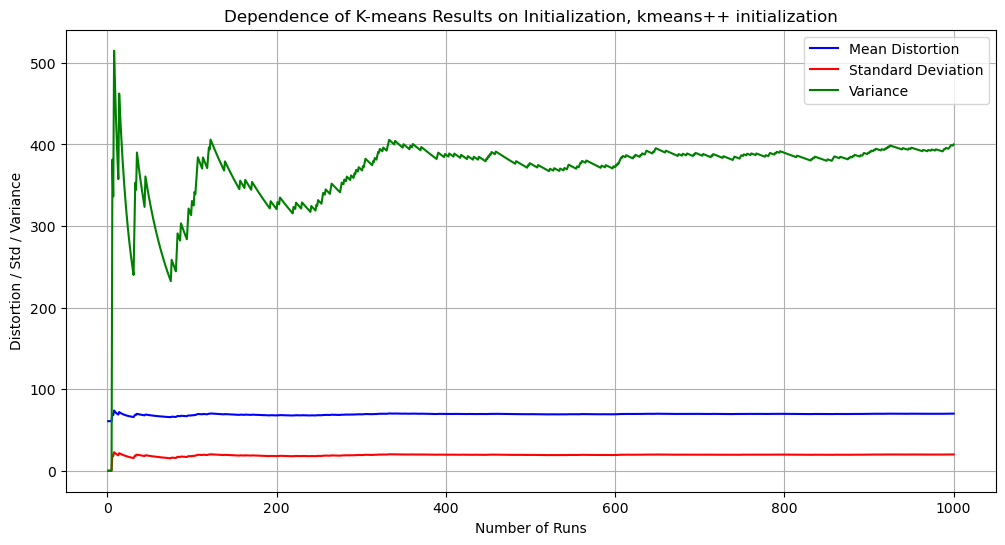

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import kmeans
import clustering_utils
import cluster_data

#first round: initialization with initial guess
testfile = r"../input/stat_Master_02_geo_s1.crs"
data = cluster_data.prepare_data_for_clustering(testfile)
data = np.array(data).T
normalized_data, data_min, data_max = cluster_data.normalize_data(data)
k = 2

num_trials = 1000
distortions = []

for _ in range(num_trials):
    result_kmeans, _ = cluster_data.run_clustering(kmeans.k_means, "K-means", normalized_data, data_min, data_max, k, plot=False)
    distortion = kmeans.compute_distortion(result_kmeans)
    distortions.append(distortion)

# Compute statistics for different numbers of runs
num_runs_list = np.arange(1, num_trials + 1)
means = [np.mean(distortions[:i]) for i in num_runs_list]
stds = [np.std(distortions[:i]) for i in num_runs_list]
variances = [np.var(distortions[:i]) for i in num_runs_list]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(num_runs_list, means, label='Mean Distortion', color='blue')
plt.plot(num_runs_list, stds, label='Standard Deviation', color='red')
plt.plot(num_runs_list, variances, label='Variance', color='green')

plt.xlabel("Number of Runs")
plt.ylabel("Distortion / Std / Variance")
plt.title("Dependence of K-means Results on Initialization, random initilization")
plt.legend()
plt.grid()
plt.show()

#second round: initilization with kmeans++

num_trials = 1000
distortions = []

for _ in range(num_trials):
    result_kmeans, _ = cluster_data.run_clustering(kmeans.k_means, "K-means", normalized_data, data_min, data_max, k, plot=False, init = "kmeans++")
    distortion = kmeans.compute_distortion(result_kmeans)
    distortions.append(distortion)

# Compute statistics for different numbers of runs
num_runs_list = np.arange(1, num_trials + 1)
means = [np.mean(distortions[:i]) for i in num_runs_list]
stds = [np.std(distortions[:i]) for i in num_runs_list]
variances = [np.var(distortions[:i]) for i in num_runs_list]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(num_runs_list, means, label='Mean Distortion', color='blue')
plt.plot(num_runs_list, stds, label='Standard Deviation', color='red')
plt.plot(num_runs_list, variances, label='Variance', color='green')

plt.xlabel("Number of Runs")
plt.ylabel("Distortion / Std / Variance")
plt.title("Dependence of K-means Results on Initialization, kmeans++ initialization")
plt.legend()
plt.grid()
plt.show()

# Vergleich der Initialisierungen:

### Zufällige Initialisierung:
Stärkere Schwankungen am Anfang, da zufällige Startwerte manchmal zu sehr schlechten Clustering-Ergebnissen führen.
Längere Konvergenzzeit, weil schlechte Startpunkte öfter auftreten.

### kmeans++-Initialisierung:
Glatterer Verlauf von Anfang an, da kmeans++ intelligentere Startwerte wählt.
Stabilisiert sich schneller, weil extreme Verzerrungen seltener auftreten.

Der wesentliche Unterschied zwischen den Methoden liegt also in der Geschwindigkeit der Konvergenz und der Stabilität der Clustering-Ergebnisse.

In [8]:
import pandas as pd

# Example clustering results
data = {
    "Algorithm": ["KMeans", "DBSCAN", "Agglomerative"],
    "Clusters": [5, 8, 6],
    "Davies-Bouldin": [0.92, 1.35, 1.12],
    "Silhouette": [0.55, 0.42, 0.48],
    "Calinski-Harabasz": [430, 290, 360],
    "Dunn Index": [0.12, 0.18, 0.14],
    "Runtime (s)": [0.45, 1.22, 0.89]
}

df = pd.DataFrame(data)
print(df)

# Optional: Pretty-print with formatting
print(df.to_string(index=False))

       Algorithm  Clusters  Davies-Bouldin  Silhouette  Calinski-Harabasz  \
0         KMeans         5            0.92        0.55                430   
1         DBSCAN         8            1.35        0.42                290   
2  Agglomerative         6            1.12        0.48                360   

   Dunn Index  Runtime (s)  
0        0.12         0.45  
1        0.18         1.22  
2        0.14         0.89  
    Algorithm  Clusters  Davies-Bouldin  Silhouette  Calinski-Harabasz  Dunn Index  Runtime (s)
       KMeans         5            0.92        0.55                430        0.12         0.45
       DBSCAN         8            1.35        0.42                290        0.18         1.22
Agglomerative         6            1.12        0.48                360        0.14         0.89
